# Dgemm trace of a real and complete HPL run

In [1]:
import io
import os
import zipfile
import pandas
import yaml
import datetime
import re
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore') # removing annoying warning
import json

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df = pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns, index_col=False)
    df.columns = df.columns.str.strip()
    df['jobid'] = int(get_yaml(archive_name, 'info.yaml')['jobid'])
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def get_json(archive_name, json_name):
    archive = zipfile.ZipFile(archive_name)
    return json.load(io.BytesIO(archive.read(json_name)))

In [2]:
def __compute_rank_mapping(archive_name, exp_id):
    '''
    Compute the mapping rank-core, based on mpirun output (thanks to the option --report-bindings).
    '''
    history = get_json(archive_name, 'history.json')
    mpirun = [cmd for cmd in history if cmd['command'].startswith('mpirun') and len(cmd['hostnames']) == 1]
    mpirun = mpirun[exp_id]['stderr'].split('\n')
    regex = re.compile('\[(?P<hostname>[a-z]+-\d+\.[a-z]+\.grid5000\.fr):\d+\] MCW rank (?P<rank>\d+) bound to socket (?P<socket>\d+)\[core (?P<core>\d+)')
    mapping = []
    for line in mpirun:
        match = regex.search(line)
        if match:
            mapping.append({'rank': int(match.group('rank')),
                            'hostname': match.group('hostname'),
                            'socket': int(match.group('socket')),
                            'core': int(match.group('core'))
                           })
    df = pandas.DataFrame(mapping)[['rank', 'hostname', 'socket', 'core']]
    df['node'] = df['hostname'].str[len('dahu-'):-len('.grenoble.grid5000.fr')].astype(int)
    df['cpu'] = df['node']*2 + df['socket'] - 2
    return df.sort_values(by='rank').reset_index(drop=True)

def compute_rank_mapping(archive_name):
    nb_exp = len(read_csv(archive_name, get_yaml(archive_name, 'info.yaml')['expfile'][0]))
    mappings = [__compute_rank_mapping(archive_name, i) for i in range(nb_exp)]
    ref = mappings[0]
    for df in mappings[1:]:
        assert ref.equals(df)
    return ref

In [3]:
archive = 'geometry/5/grenoble_2020-07-09_1939719.zip'

def __read_archive(archive_name, exp_id):
    blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k', 'lda', 'ldb', 'ldc', 'layout', 'TransA', 'TransB']
    df = read_csv(archive_name, 'trace_blas_%d.csv' % exp_id, columns=blas_col)
    print('Read trace n°%d from %s: %6d lines' % (exp_id, archive_name, len(df)))
    df['start'] = df.timestamp
    df['end'] = df.timestamp + df.duration
    df = df[['jobid', 'function', 'start', 'end', 'rank', 'm', 'n', 'k', 'duration']]
    df['rank+1'] = df['rank'] + 1
    df['function'] = df['function'].str.strip()
    df['exp_id'] = exp_id
    df['block_size'] = read_csv(archive_name, get_yaml(archive_name, 'info.yaml')['expfile'][0]).iloc[exp_id].block_size
    mapping = compute_rank_mapping(archive_name)
    df = df.set_index('rank').join(mapping.set_index('rank')).reset_index()
    return df

def read_archive(archive_name):
    nb_exp = len(read_csv(archive_name, get_yaml(archive_name, 'info.yaml')['expfile'][0]))
    return pandas.concat([__read_archive(archive_name, i) for i in range(nb_exp)])

traces = read_archive(archive)

traces = traces[traces['function'] == 'dgemm']
traces.head()

Read trace n°0 from geometry/5/grenoble_2020-07-09_1939719.zip: 1996353 lines


,rank,jobid,function,start,end,m,n,k,duration,rank+1,exp_id,block_size,hostname,socket,core,node,cpu
0,0,1939719,dgemm,0.000000,0.000843,249998,2,2,0.000843,1,0,128,dahu-3.grenoble.grid5000.fr,0,0,3,4
1,0,1939719,dgemm,0.001884,0.003511,249996,4,4,0.001626,1,0,128,dahu-3.grenoble.grid5000.fr,0,0,3,4
2,0,1939719,dgemm,0.004703,0.005522,249994,2,2,0.000818,1,0,128,dahu-3.grenoble.grid5000.fr,0,0,3,4
3,0,1939719,dgemm,0.006360,0.009573,249992,8,8,0.003214,1,0,128,dahu-3.grenoble.grid5000.fr,0,0,3,4
4,0,1939719,dgemm,0.010593,0.011428,249990,2,2,0.000836,1,0,128,dahu-3.grenoble.grid5000.fr,0,0,3,4


In [4]:
for size in [128, 256, 512]:
    tmp = traces[(traces['block_size'] == size) & (traces['node'] == traces['node'].min()) & (traces['core'] == 0)]
    print(tmp['duration'].sum())
    tmp = tmp[['function', 'm', 'n', 'k']]
    tmp['lda'] = tmp[['m', 'n', 'k']].max(axis=1)
    tmp['ldb'] = tmp['lda']
    tmp['ldc'] = tmp['lda']
    for col in ['m', 'n', 'k', 'lda', 'ldb', 'ldc']:
        tmp[col] = tmp[col].astype(int)
    tmp.to_csv('/tmp/exp_%d.csv' % size, header=False, index=False)

917.889998269
0.0
0.0


In [5]:
traces[['jobid', 'hostname', 'node']].drop_duplicates().sort_values(by=['jobid', 'node']).reset_index(drop=True)

,jobid,hostname,node
0,1939719,dahu-3.grenoble.grid5000.fr,3
1,1939719,dahu-4.grenoble.grid5000.fr,4
2,1939719,dahu-6.grenoble.grid5000.fr,6
3,1939719,dahu-7.grenoble.grid5000.fr,7
4,1939719,dahu-8.grenoble.grid5000.fr,8
5,1939719,dahu-9.grenoble.grid5000.fr,9
6,1939719,dahu-13.grenoble.grid5000.fr,13
7,1939719,dahu-23.grenoble.grid5000.fr,23
8,1939719,dahu-25.grenoble.grid5000.fr,25
9,1939719,dahu-26.grenoble.grid5000.fr,26


## HPL result

In [6]:
res = read_csv(archive, 'results.csv')
res[['jobid', 'matrix_size', 'block_size', 'time']].sort_values(by='matrix_size')

,jobid,matrix_size,block_size,time
0,1939719,250000,128,1710.37


## Checking the parameters

In [7]:
read_csv(archive, 'exp_hpl_small.csv')

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process,jobid
0,250000,128,1,480,1,2,2,1,0,8,32,1,1939719


## Prediction error on the duration

In [8]:
model_file = '/tmp/dgemm_generic_128.yaml'
!sha256sum $model_file
!echo
!head -n 28 $model_file

163aa21d41074673d6f6eaa22510d0f574ea46d8e1fa6316cf6000b9604037e7  /tmp/dgemm_generic_128.yaml

info:
  avg_gflops: 28.927805769083317
  avg_latency: 2.5739354838709672e-06
  cluster: dahu
  experiment_date:
  - '2020-07-08T06:25:34.000000000'
  - '2020-07-08T06:51:56.000000000'
  - '2020-07-08T07:17:02.000000000'
  expfile_hash:
  - 7182bdc09785b7b57fa9065f096c0774467e68b7da37e920868663865b6f4242
  - 534e87a021d988bd1f50ee1b4aa15065b1fc465bde5df2e29ad6d83878d59e48
  - 08090da5c4cb27c6e3b81112ddea75febf3ca40f342fb5d8f61ad55a6a82f69a
  function: dgemm
  heterogeneity_coefficient: 0.03970299378614987
  jobid:
  - 1939567
  - 1939568
  - 1939569
  nb_nodes: 31
  variability_coefficient: 0.003908670519883098
metadata:
  archive_file:
  - geometry/1/grenoble_2020-07-08_1939567.zip
  - geometry/1/grenoble_2020-07-08_1939568.zip
  - geometry/1/grenoble_2020-07-08_1939569.zip
  cashew_git: f6e1abe82ebba1eec668652189985c631c10b5b5
  file_creation_date: '2020-07-08 16:18:57.977135'
  granularity:

In [9]:
with open(model_file) as f:
    model = pandas.DataFrame(yaml.load(f)['model'])
    model['cpu_id'] -= 2  # the numbering start at 2 in my yaml files, but at 0 here

In [10]:
traces['pred'] = 0
traces['mnk'] = traces.m * traces.n * traces.k
traces['mn'] = traces.m * traces.n
traces['mk'] = traces.m * traces.k
traces['nk'] = traces.n * traces.k
for cpu in traces['cpu'].unique():
    block_size = traces['block_size'].unique()
    assert len(block_size) == 1
    block_size = block_size[0]
    reg = model
    reg = reg[reg['cpu_id'] == cpu]
    assert len(reg) == 1
    reg = list(reg.iterrows())[0][1]
    mask = (traces['cpu'] == cpu) & (traces['block_size'] == block_size)
    traces.loc[mask, 'pred'] += reg['intercept']
    for prod in ['mnk', 'mn', 'mk', 'nk']:
        traces.loc[mask, 'pred'] += reg[prod] * traces[mask][prod]

In [11]:
duration_thresh = 0.1

In [12]:
traces['error'] = (traces['pred'] - traces['duration']) / traces['duration']
traces['abs_error'] = traces['error'].abs()

In [13]:
traces[traces.duration > duration_thresh]['error'].describe()

count    1.649573e+06
mean     2.500511e-03
std      2.647243e-02
min     -1.438127e-01
25%     -1.294954e-02
50%      6.856031e-05
75%      1.645821e-02
max      2.039131e-01
Name: error, dtype: float64

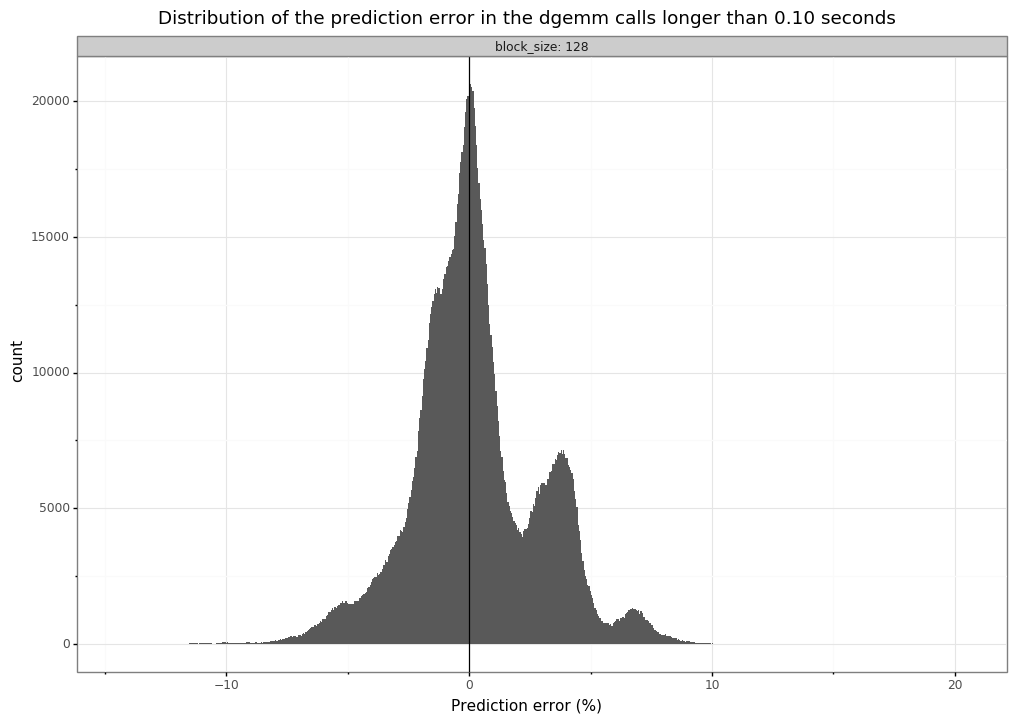

<ggplot: (-9223363246634605280)>

In [14]:
traces['error_perc'] = traces['error']*100
plot = ggplot(traces[traces.duration > duration_thresh], aes(x='error_perc')) + geom_histogram() + theme_bw()
plot = plot + facet_wrap('block_size', nrow=3, labeller='label_both') + xlab('Prediction error (%)')
plot = plot + ggtitle('Distribution of the prediction error in the dgemm calls longer than %.2f seconds' % duration_thresh)
plot = plot + geom_vline(xintercept=0)
plot

In [15]:
traces.head()

,rank,jobid,function,start,end,m,n,k,duration,rank+1,...,node,cpu,pred,mnk,mn,mk,nk,error,abs_error,error_perc
0,0,1939719,dgemm,0.000000,0.000843,249998,2,2,0.000843,1,...,3,4,0.000420,999992,499996,499996,4,-0.501836,0.501836,-50.183599
1,0,1939719,dgemm,0.001884,0.003511,249996,4,4,0.001626,1,...,3,4,0.000980,3999936,999984,999984,16,-0.397348,0.397348,-39.734760
2,0,1939719,dgemm,0.004703,0.005522,249994,2,2,0.000818,1,...,3,4,0.000420,999976,499988,499988,4,-0.486911,0.486911,-48.691069
3,0,1939719,dgemm,0.006360,0.009573,249992,8,8,0.003214,1,...,3,4,0.002529,15999488,1999936,1999936,64,-0.213045,0.213045,-21.304483
4,0,1939719,dgemm,0.010593,0.011428,249990,2,2,0.000836,1,...,3,4,0.000420,999960,499980,499980,4,-0.497508,0.497508,-49.750827


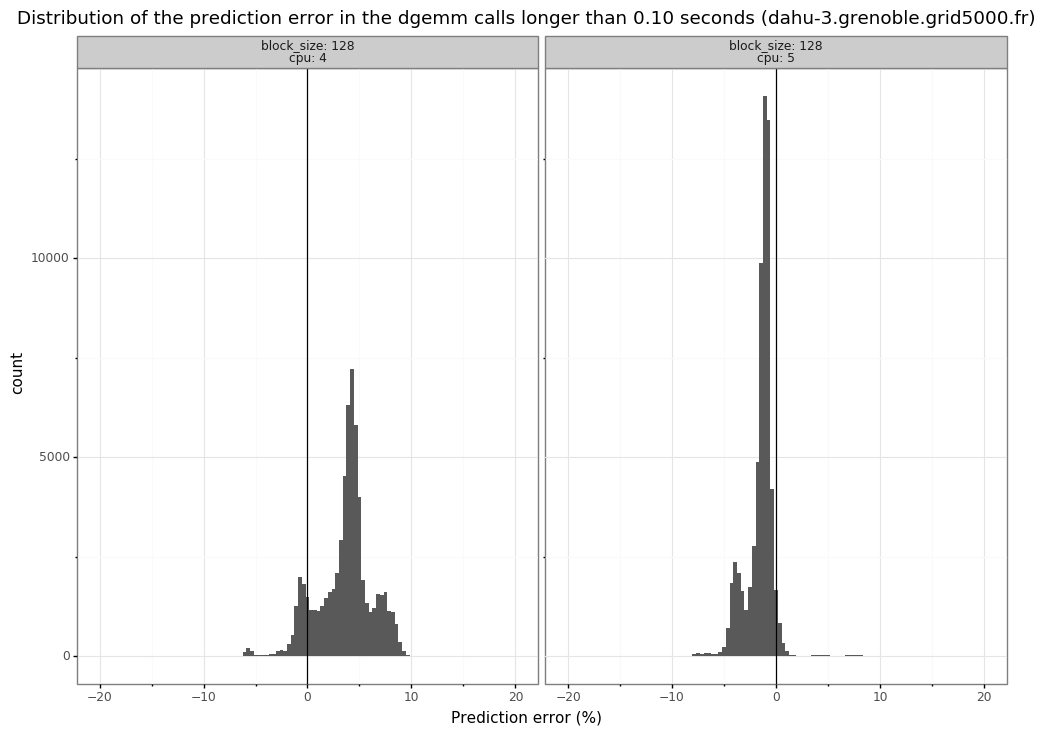

<ggplot: (8790311079565)>


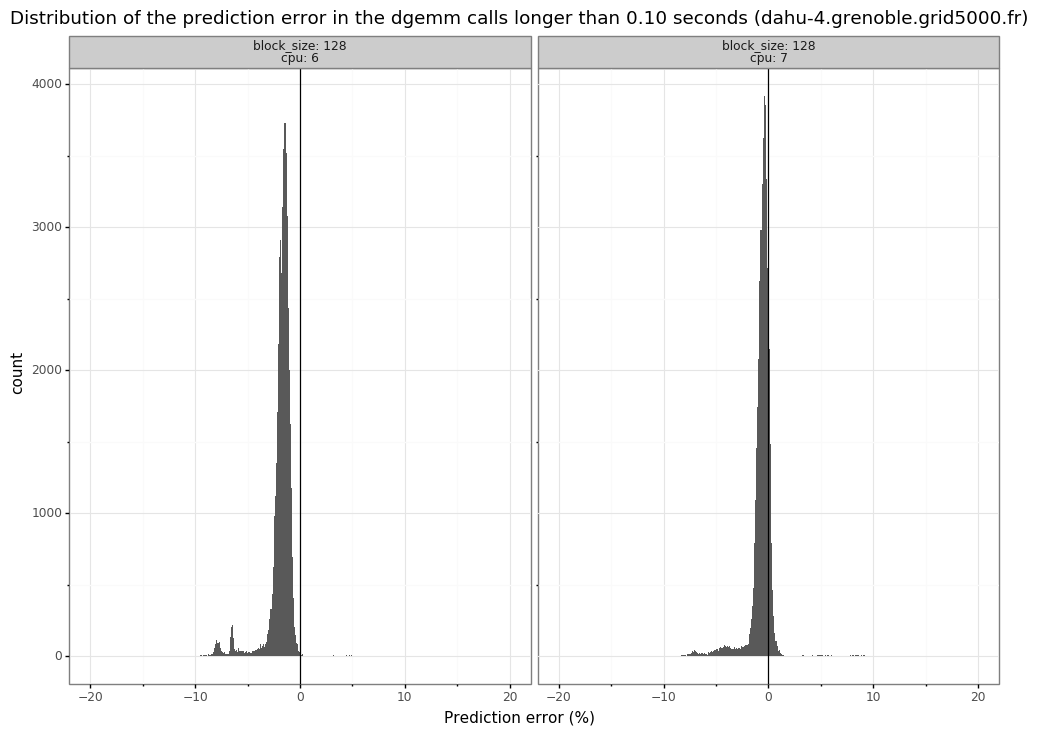

<ggplot: (8790311287602)>


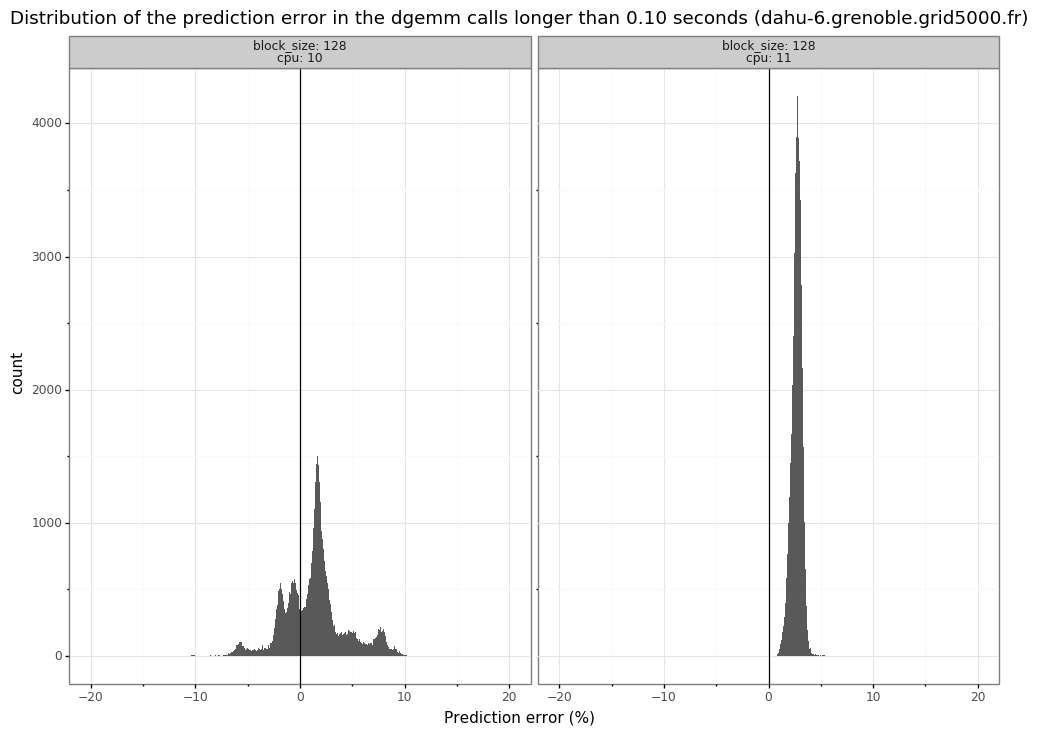

<ggplot: (8790311209213)>


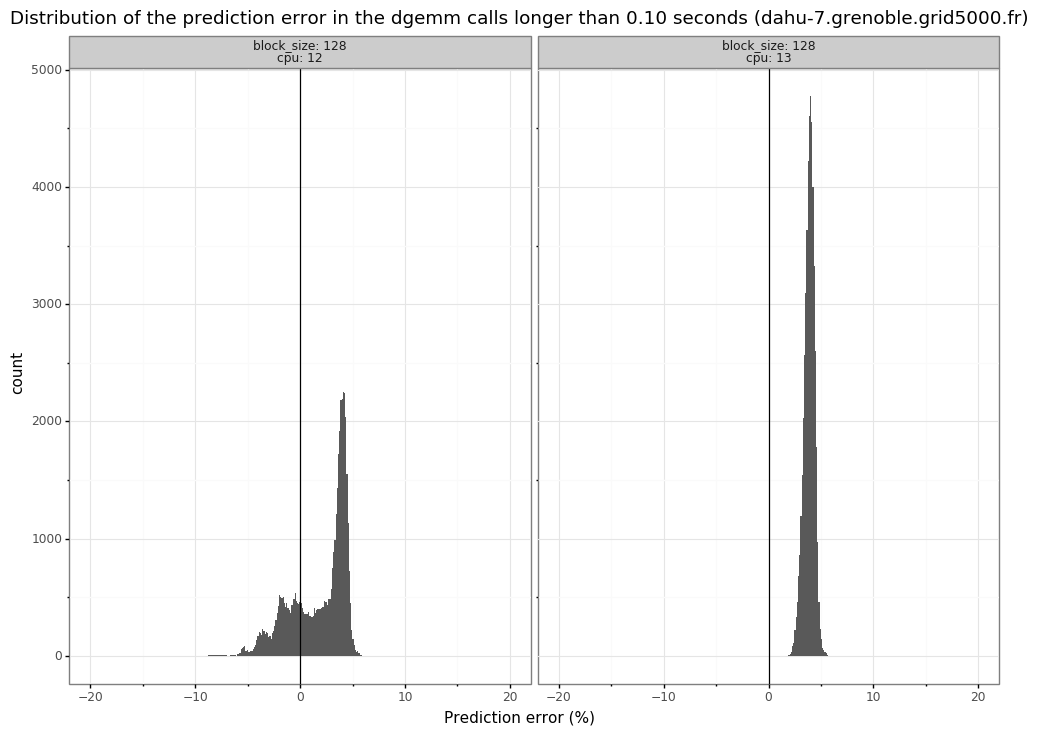

<ggplot: (-9223363246580451552)>


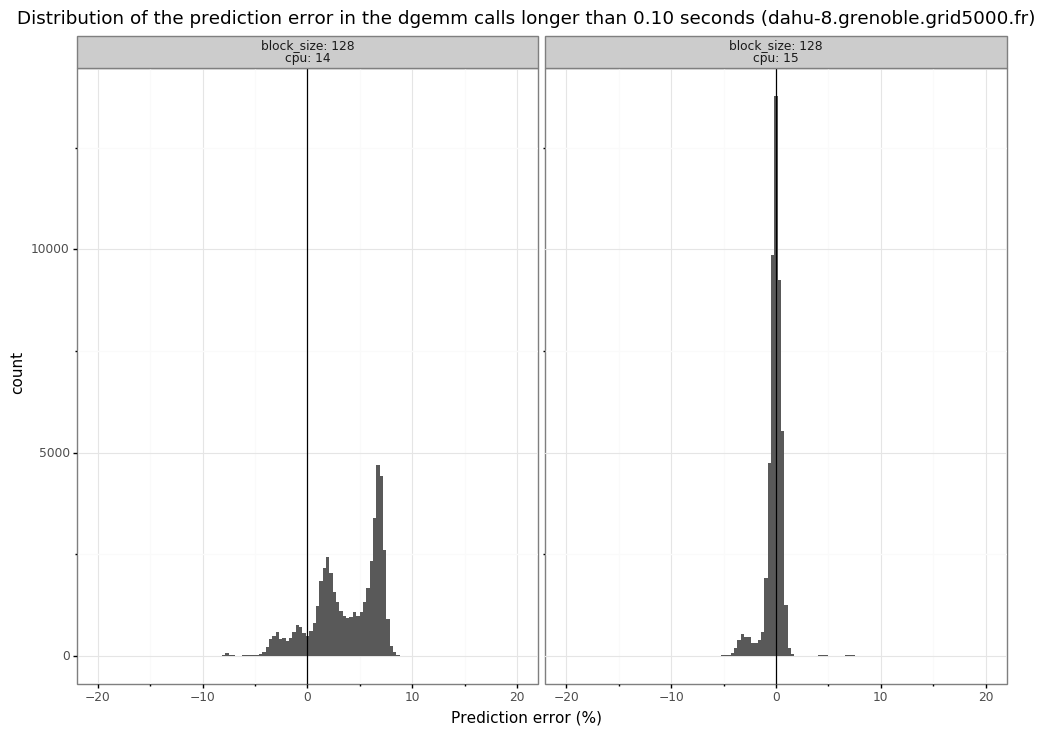

<ggplot: (8790311212380)>


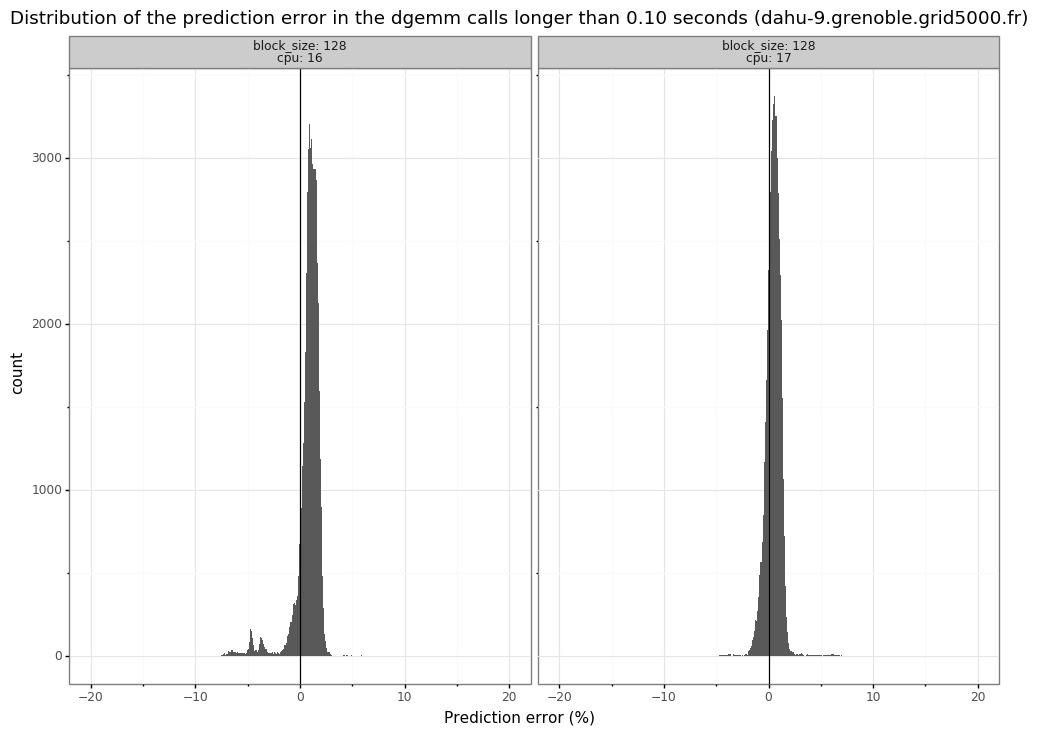

<ggplot: (-9223363246543578066)>


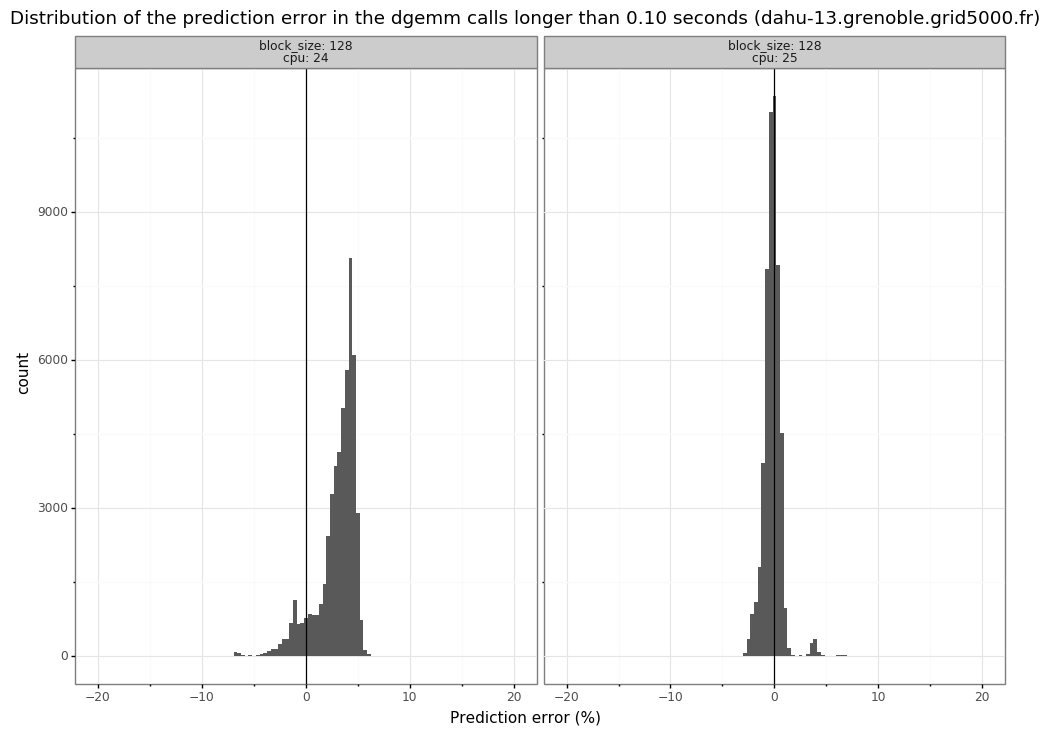

<ggplot: (-9223363246634633121)>


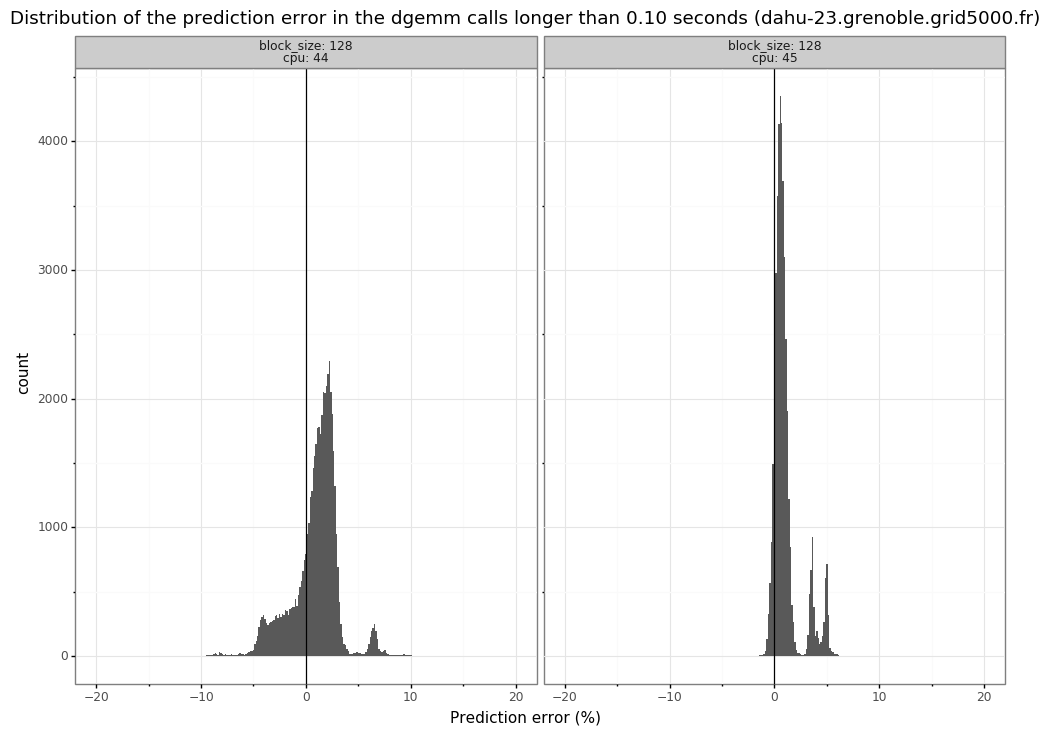

<ggplot: (-9223363246543617753)>


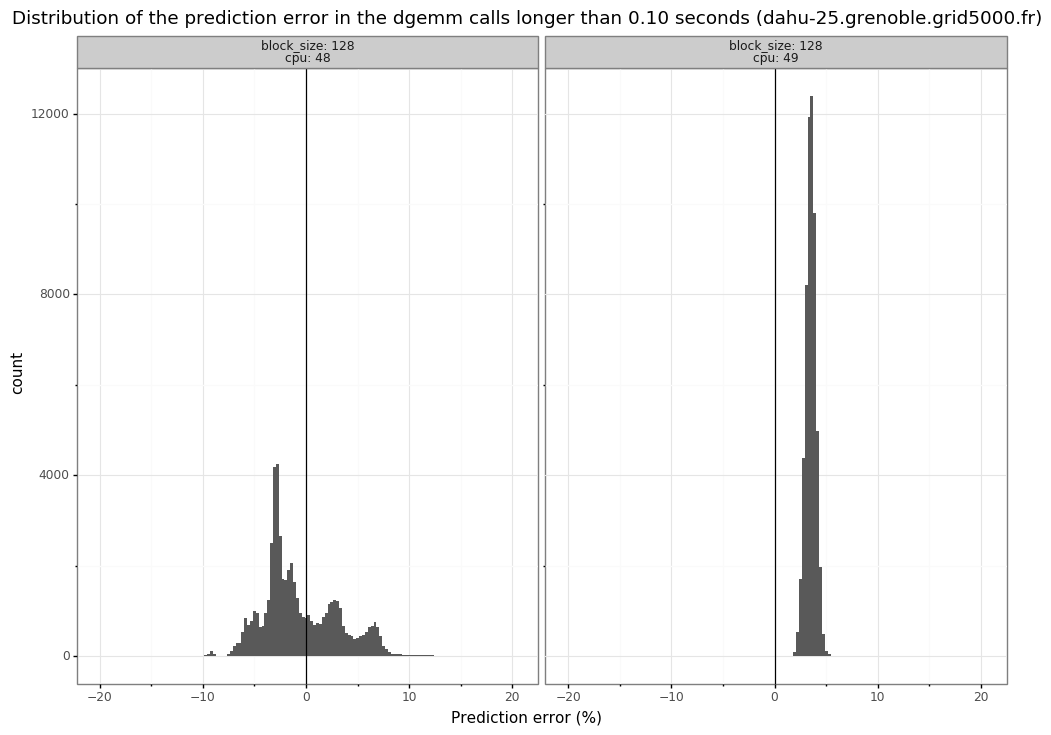

<ggplot: (8790311031844)>


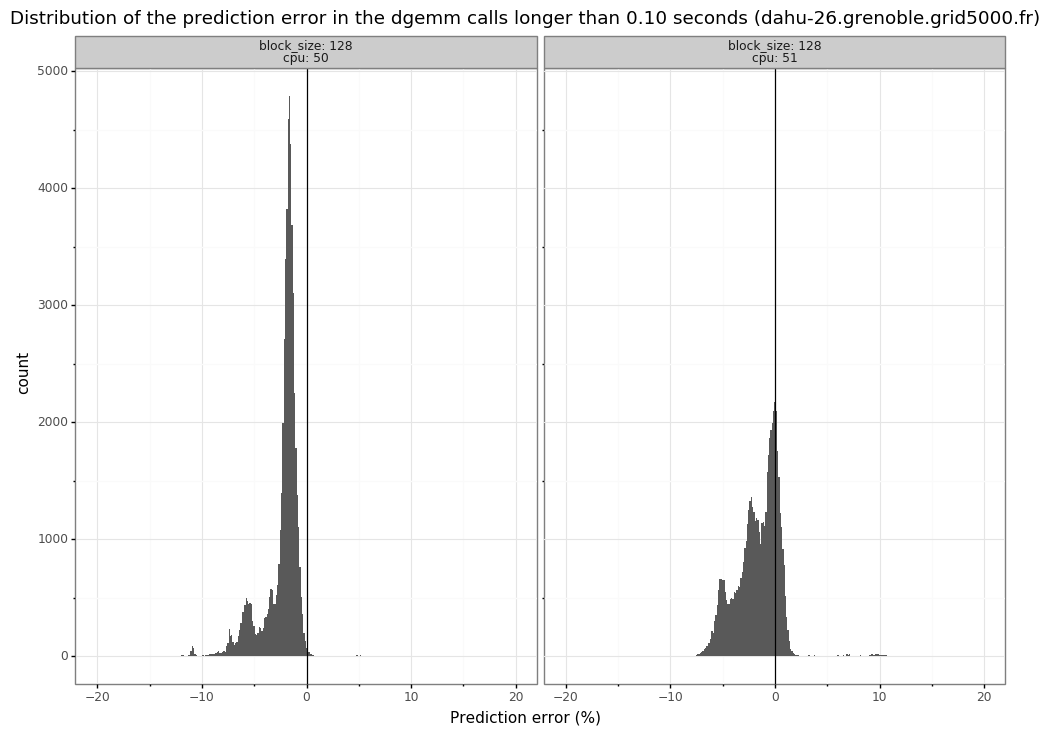

<ggplot: (8790309794045)>


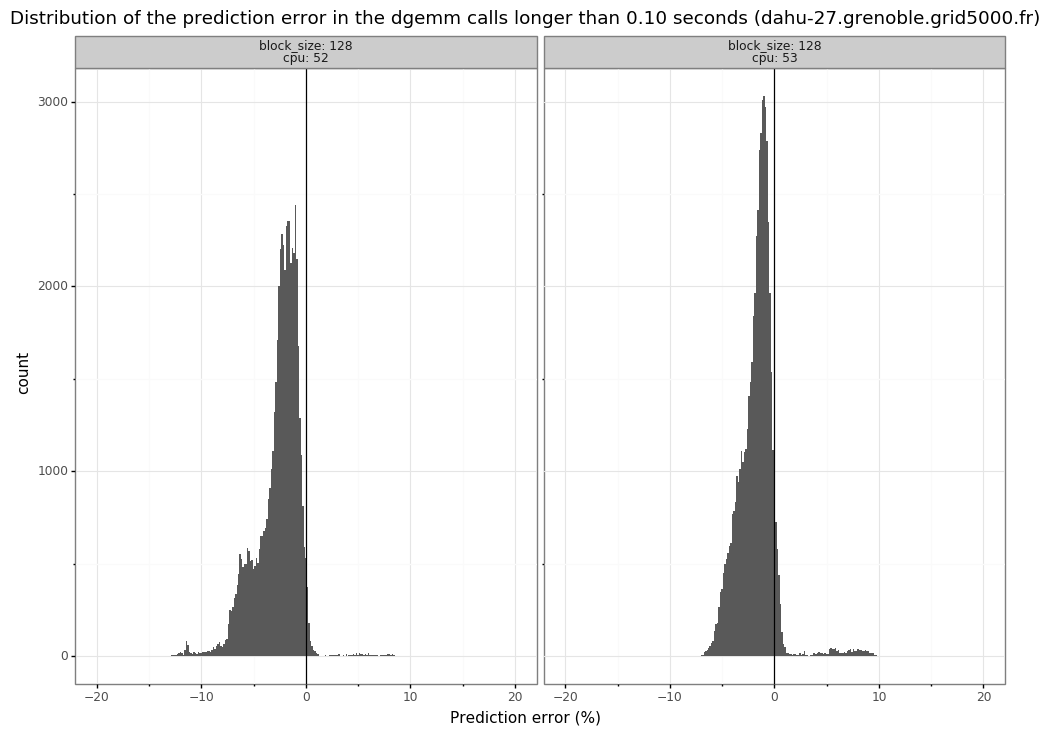

<ggplot: (-9223363246543700634)>


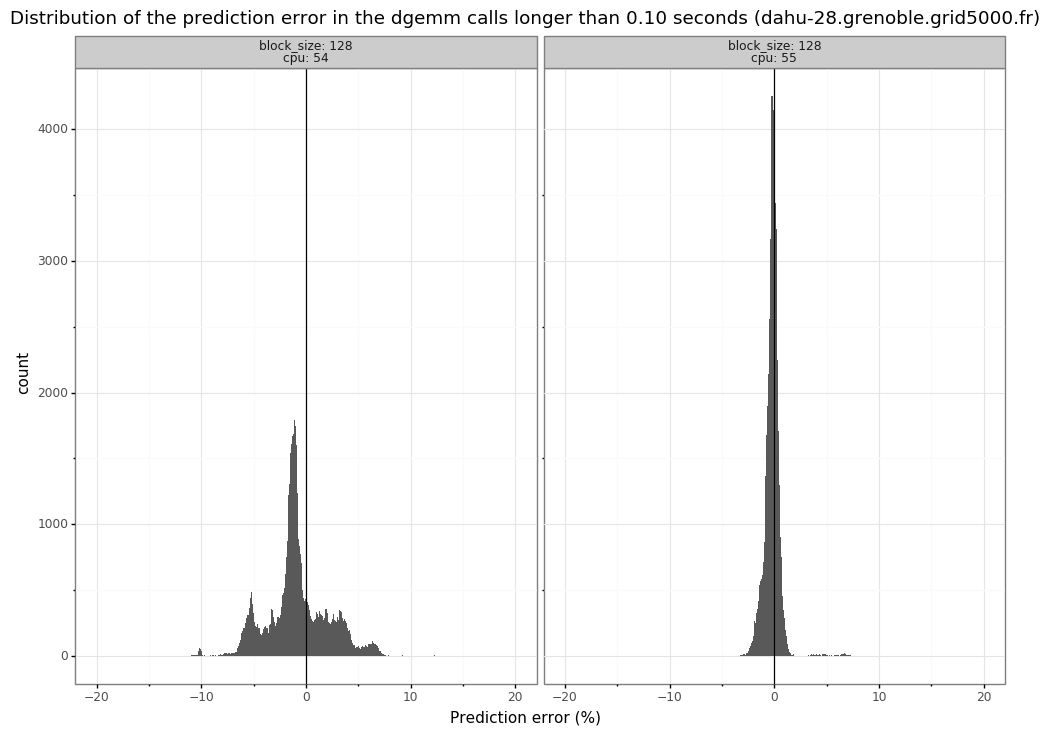

<ggplot: (-9223363246543734724)>


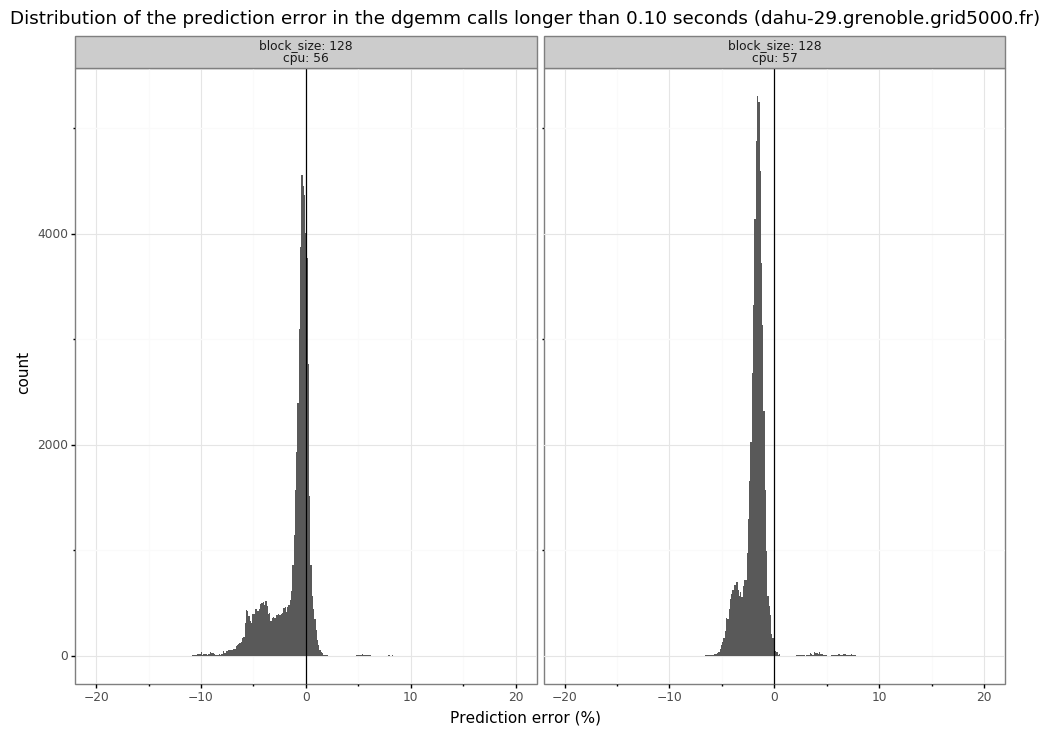

<ggplot: (-9223363246611672772)>


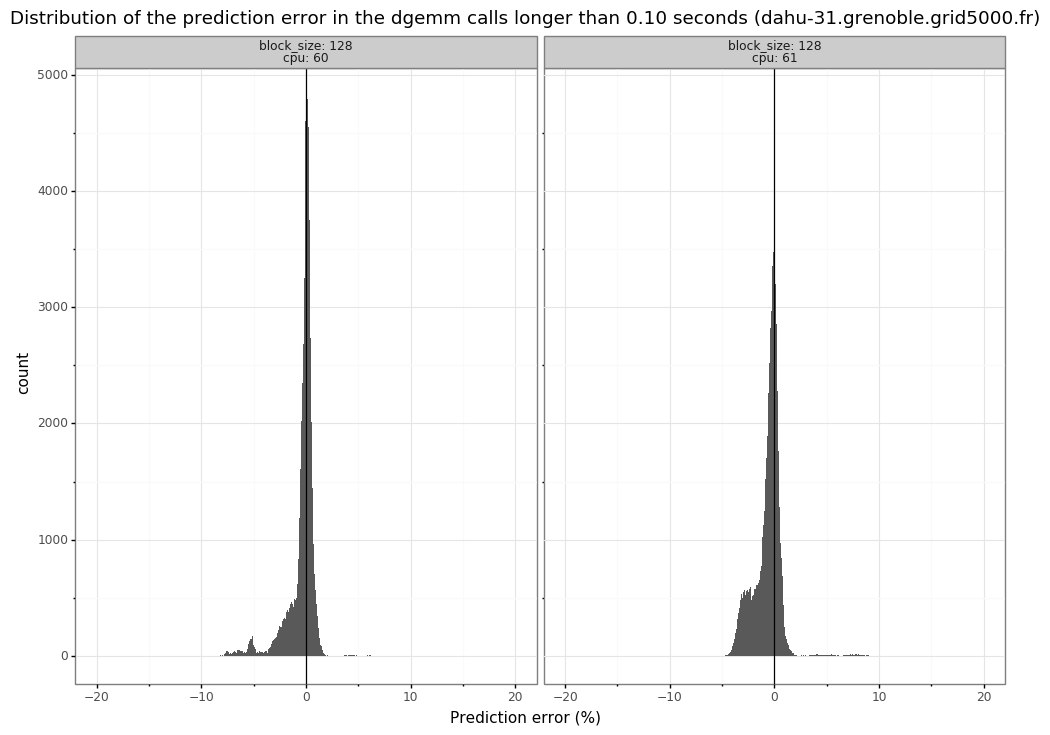

<ggplot: (8790311032566)>


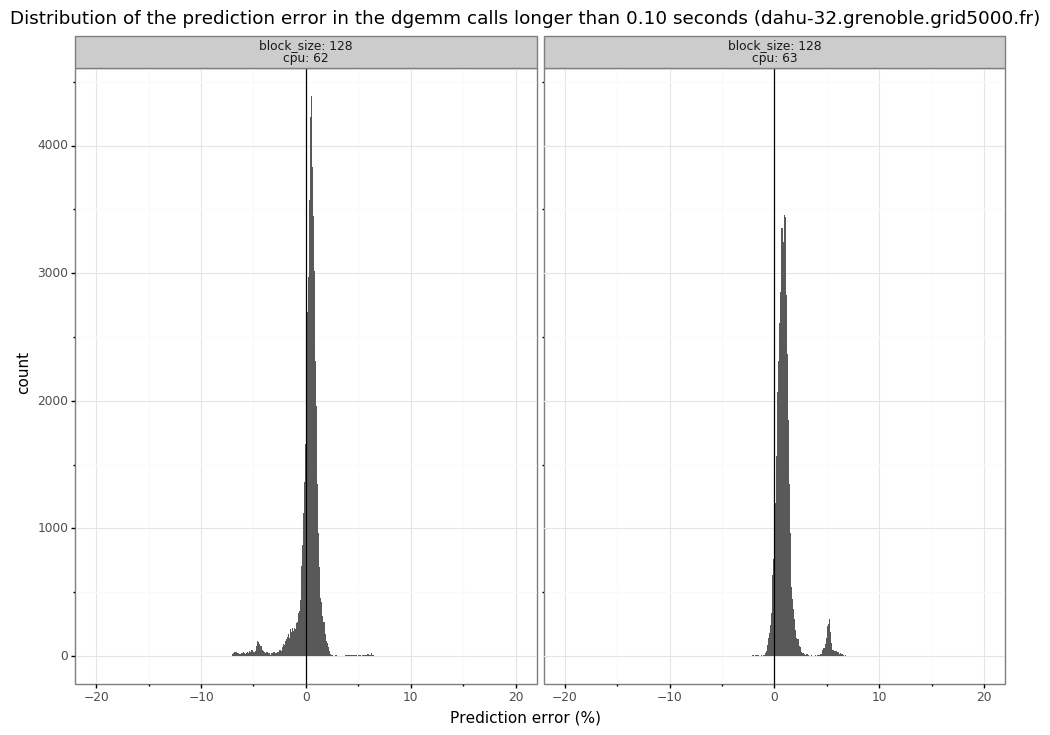

<ggplot: (8790311032419)>


In [16]:
traces['cpu_id'] = traces['cpu']
for node in sorted(traces['node'].unique()):
    tmp = traces[(traces.duration > duration_thresh) & (traces['node'] == node)]
    hostname = tmp.iloc[0]['hostname']
    plot = ggplot(tmp) + aes(x='error_perc') + geom_histogram() + theme_bw()
    plot = plot + facet_wrap(['block_size', 'cpu'], ncol=2, labeller='label_both') + xlab('Prediction error (%)')
    plot = plot + ggtitle('Distribution of the prediction error in the dgemm calls longer than %.2f seconds (%s)' % (duration_thresh, hostname))
    plot = plot + geom_vline(xintercept=0)
    plot = plot + expand_limits(x=(-20, 20))
    print(plot)

In [17]:
error_thresh = 0.08

In [18]:
tmp = traces[(traces['abs_error'] > error_thresh) & (traces['duration'] > duration_thresh)]
tmp = tmp[tmp['abs_error'] < tmp['abs_error'].quantile(0.95)] # removing "outliers"
print(len(tmp))

# Creating one 'fake' point with error of 0 to get the color scale starting at 0
some_row = tmp.iloc[0]
some_row['error'] = 0
some_row['abs_error'] = 0
some_row['error_perc'] = 0
tmp = tmp.append(some_row, ignore_index=True)
tmp.sort_values(by='abs_error', axis=0, ascending=False).head()

8517


,rank,jobid,function,start,end,m,n,k,duration,rank+1,...,cpu,pred,mnk,mn,mk,nk,error,abs_error,error_perc,cpu_id
6568,323,1939719,dgemm,943.8836,944.117471,178448,128,128,0.233872,324,...,52,0.206995,2923692032,22841344,22841344,16384,-0.114922,0.114922,-11.492178,52
5024,256,1939719,dgemm,1401.7710,1401.918458,124432,128,128,0.147458,257,...,48,0.164397,2038693888,15927296,15927296,16384,0.114873,0.114873,11.487262,48
6813,335,1939719,dgemm,374.0399,374.335636,225680,128,128,0.295736,336,...,52,0.261773,3697541120,28887040,28887040,16384,-0.114845,0.114845,-11.484489,52
6761,335,1939719,dgemm,273.7654,274.071195,233360,128,128,0.305795,336,...,52,0.270680,3823370240,29870080,29870080,16384,-0.114834,0.114834,-11.483403,52
3668,72,1939719,dgemm,131.6137,132.396030,240784,384,128,0.782330,73,...,10,0.872162,11835015168,92461056,30820352,49152,0.114825,0.114825,11.482535,10


In [19]:
melted = tmp.melt(id_vars=['jobid', 'block_size', 'hostname', 'cpu', 'm', 'n', 'k', 'mnk', 'mn', 'mk', 'nk', 'start', 'error', 'abs_error'], value_vars=['duration', 'pred'], var_name='kind', value_name='time')
melted['gflops'] = 2*melted['mnk'] / melted['time'] * 1e-9

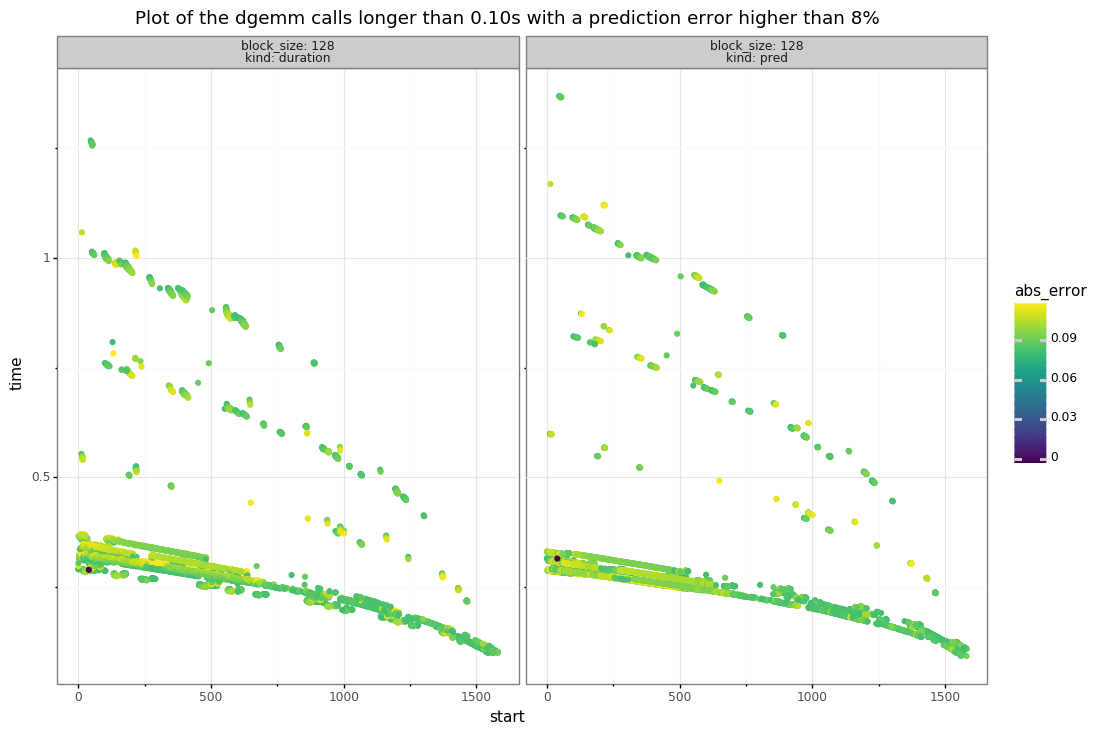

<ggplot: (-9223363246580454975)>


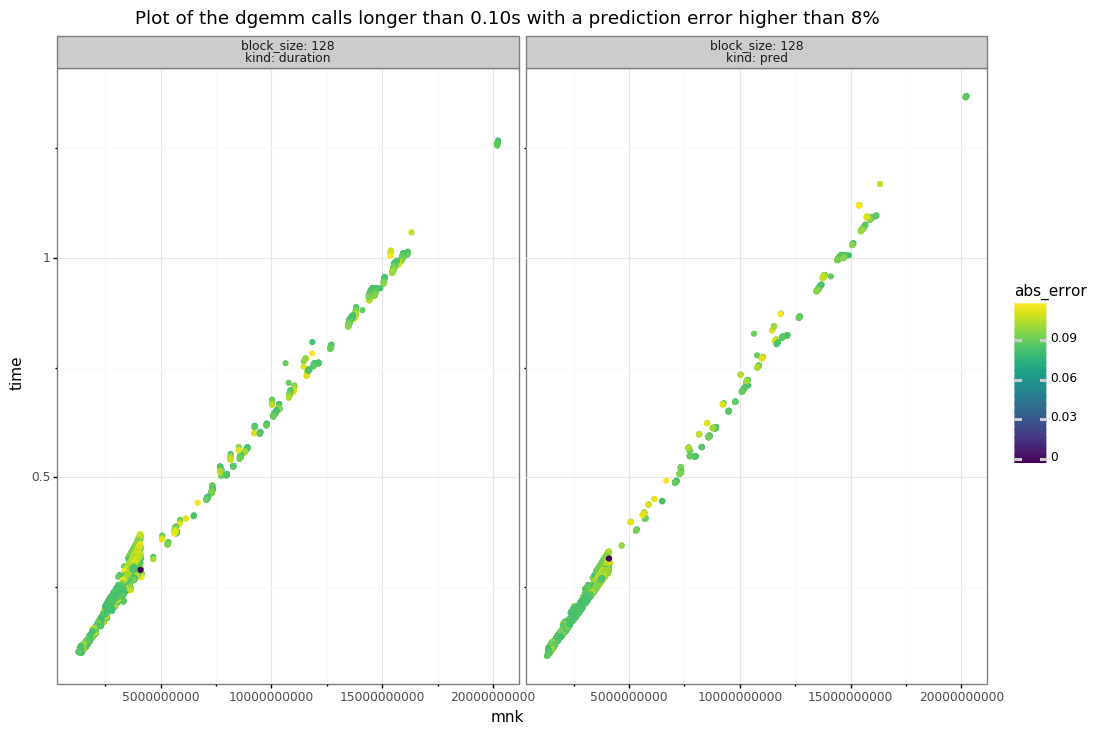

<ggplot: (8790311056809)>


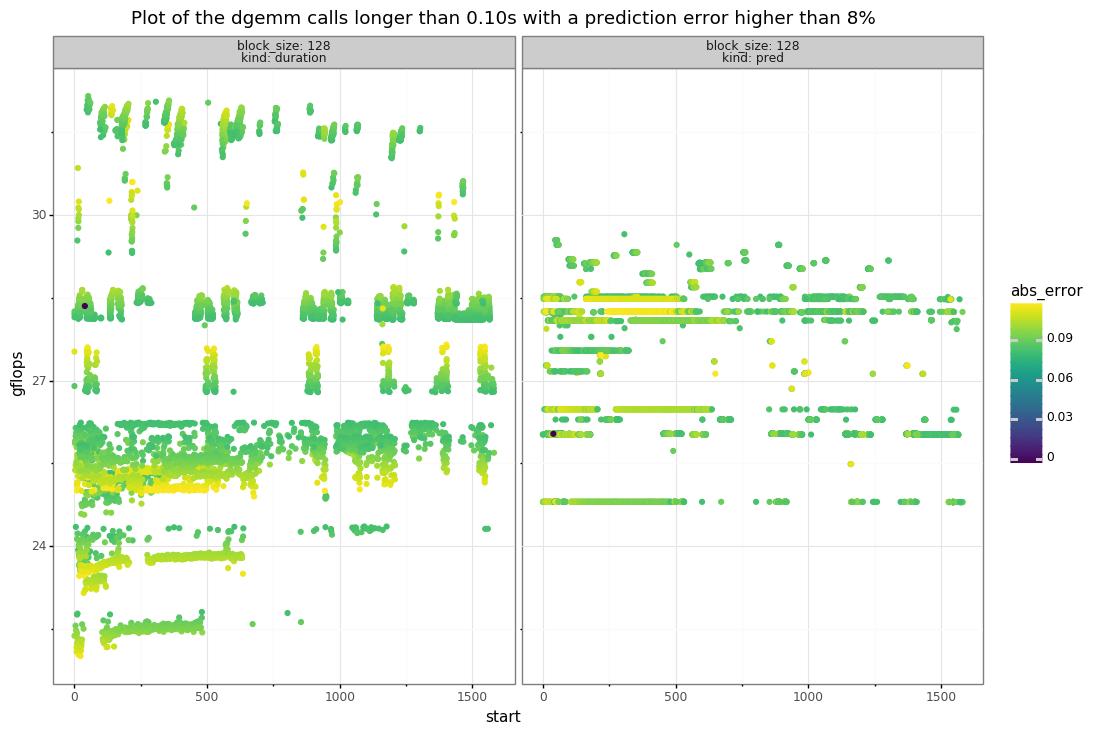

<ggplot: (-9223363246581150071)>


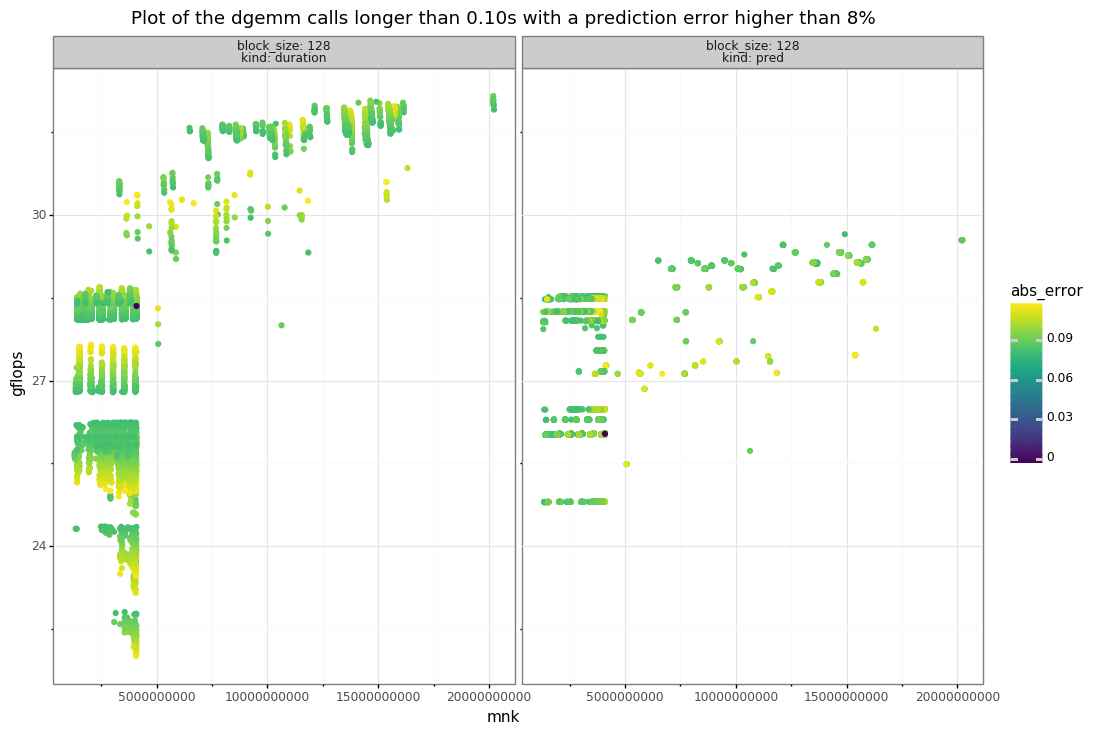

<ggplot: (-9223363246544983450)>


In [20]:
p = ggplot(melted, aes(color='abs_error')) + theme_bw() + facet_wrap(['block_size', 'kind'], ncol=2, labeller='label_both')
p = p + ggtitle('Plot of the dgemm calls longer than %.2fs with a prediction error higher than %d%%' % (duration_thresh, error_thresh*100))
for y in ['time', 'gflops']:
    for x in ['start', 'mnk']:
        print(p + geom_point(aes(x=x, y=y)))

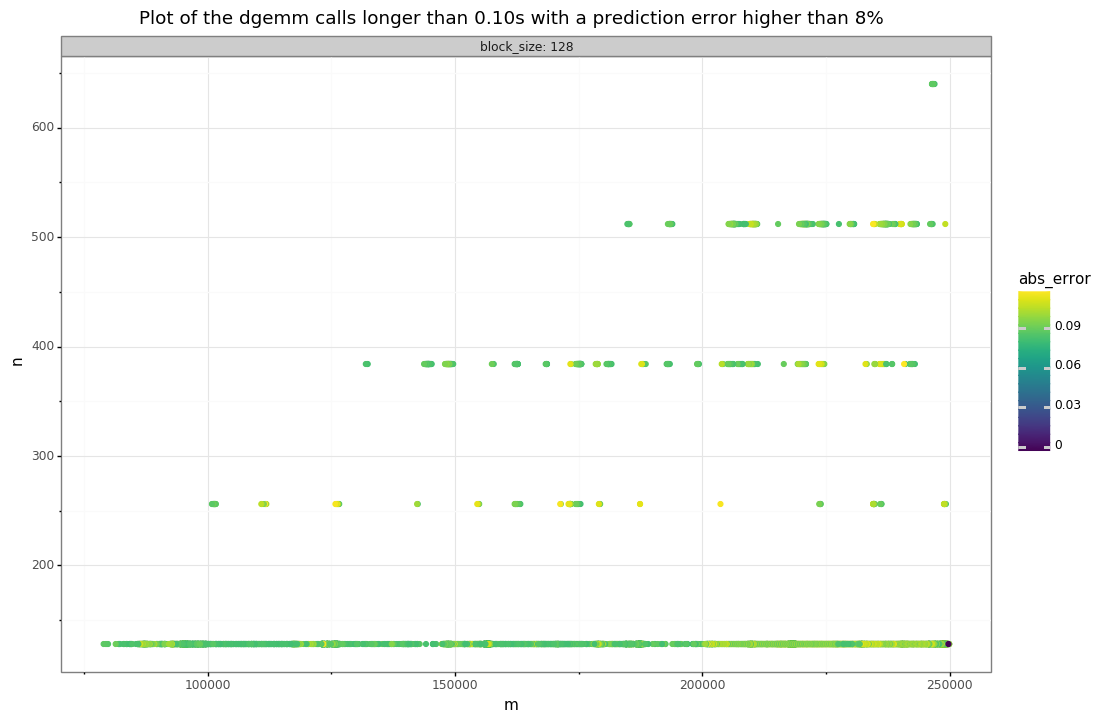

<ggplot: (8790263723363)>


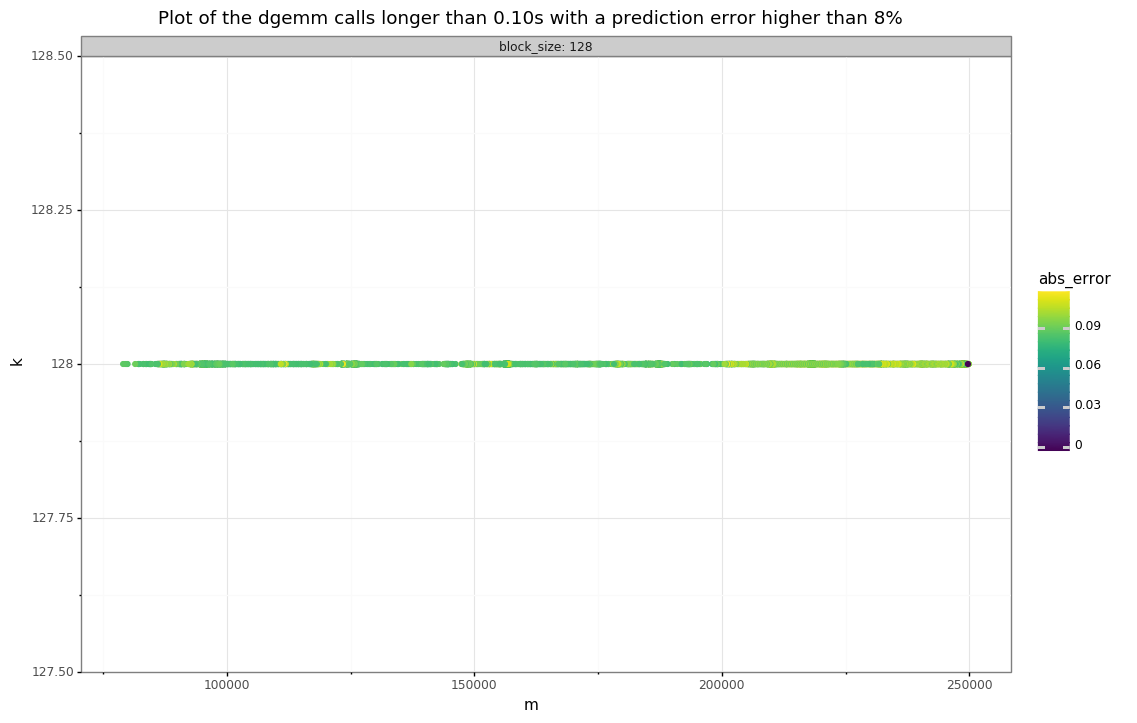

<ggplot: (8790263696865)>


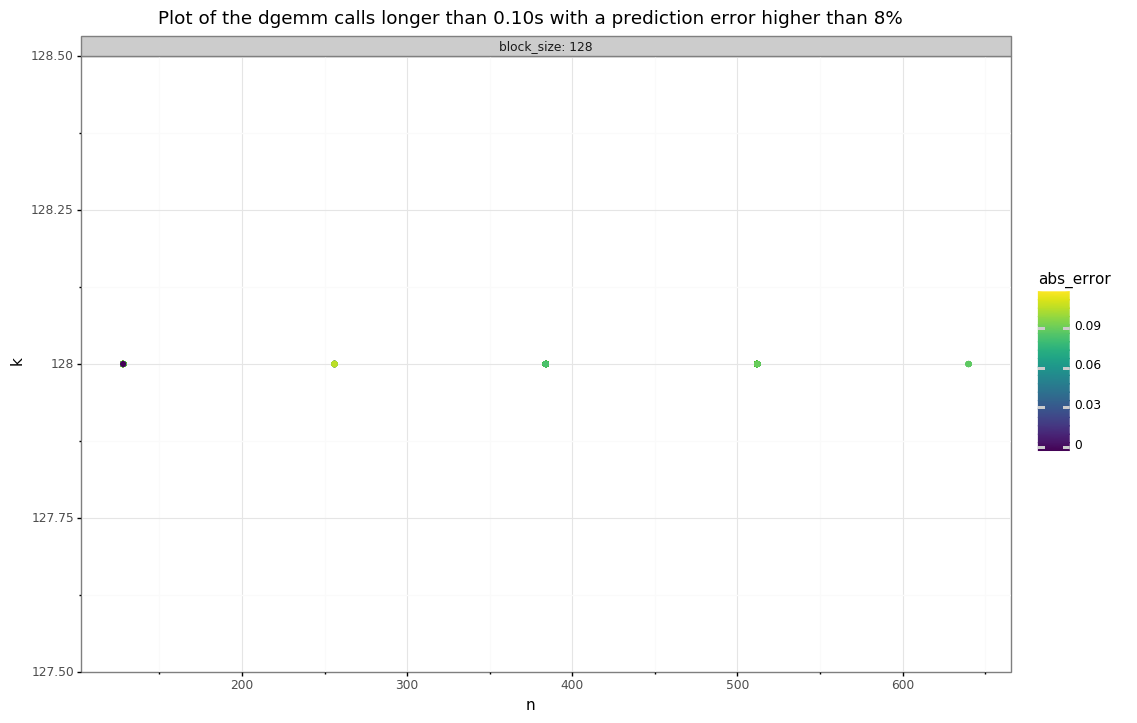

<ggplot: (-9223363246593411033)>


In [21]:
p = ggplot(tmp, aes(color='abs_error')) + theme_bw() + facet_wrap(['block_size'], ncol=3, labeller='label_both')
p = p + ggtitle('Plot of the dgemm calls longer than %.2fs with a prediction error higher than %d%%' % (duration_thresh, error_thresh*100))
for x, y in ['mn', 'mk', 'nk']:
    print(p + geom_point(aes(x=x, y=y)))

In [22]:
summary = traces.groupby(['block_size', 'hostname', 'node', 'socket', 'cpu', 'rank'])[['duration', 'pred', 'mnk']].sum().reset_index()
summary['gflops_real'] = 2*summary['mnk'] / summary['duration'] * 1e-9
summary['gflops_pred'] = 2*summary['mnk'] / summary['pred'] * 1e-9
summary['error'] = (summary['pred'] - summary['duration']) / summary['duration']
summary['abs_error'] = summary['error'].abs()
summary.sort_values(by='abs_error', ascending=False).head(n=10)

,block_size,hostname,node,socket,cpu,rank,duration,pred,mnk,gflops_real,gflops_pred,error,abs_error
321,128,dahu-4.grenoble.grid5000.fr,4,0,6,33,707.012170,661.105177,9283757009792,26.261944,28.085567,-0.064931,0.064931
424,128,dahu-8.grenoble.grid5000.fr,8,0,14,136,709.515579,741.238135,9744364298240,27.467654,26.292129,0.044710,0.044710
423,128,dahu-8.grenoble.grid5000.fr,8,0,14,135,709.229191,740.538389,9735165075456,27.452804,26.292128,0.044145,0.044145
232,128,dahu-3.grenoble.grid5000.fr,3,0,4,8,919.724085,959.977654,12496023009280,27.173417,26.033987,0.043767,0.043767
231,128,dahu-3.grenoble.grid5000.fr,3,0,4,7,919.127843,959.156029,12485698385920,27.168578,26.034760,0.043550,0.043550
131,128,dahu-27.grenoble.grid5000.fr,27,0,52,323,836.734932,801.080822,11317164007424,27.050775,28.254737,-0.042611,0.042611
422,128,dahu-8.grenoble.grid5000.fr,8,0,14,134,709.647067,739.838006,9725957464064,27.410689,26.292127,0.042544,0.042544
143,128,dahu-27.grenoble.grid5000.fr,27,0,52,335,841.589025,806.929725,11408076333056,27.110801,28.275266,-0.041183,0.041183
407,128,dahu-7.grenoble.grid5000.fr,7,1,13,119,674.785765,702.427682,9586836660224,28.414460,27.296295,0.040964,0.040964
406,128,dahu-7.grenoble.grid5000.fr,7,1,13,118,674.338130,701.782304,9577494831104,28.405616,27.294774,0.040698,0.040698


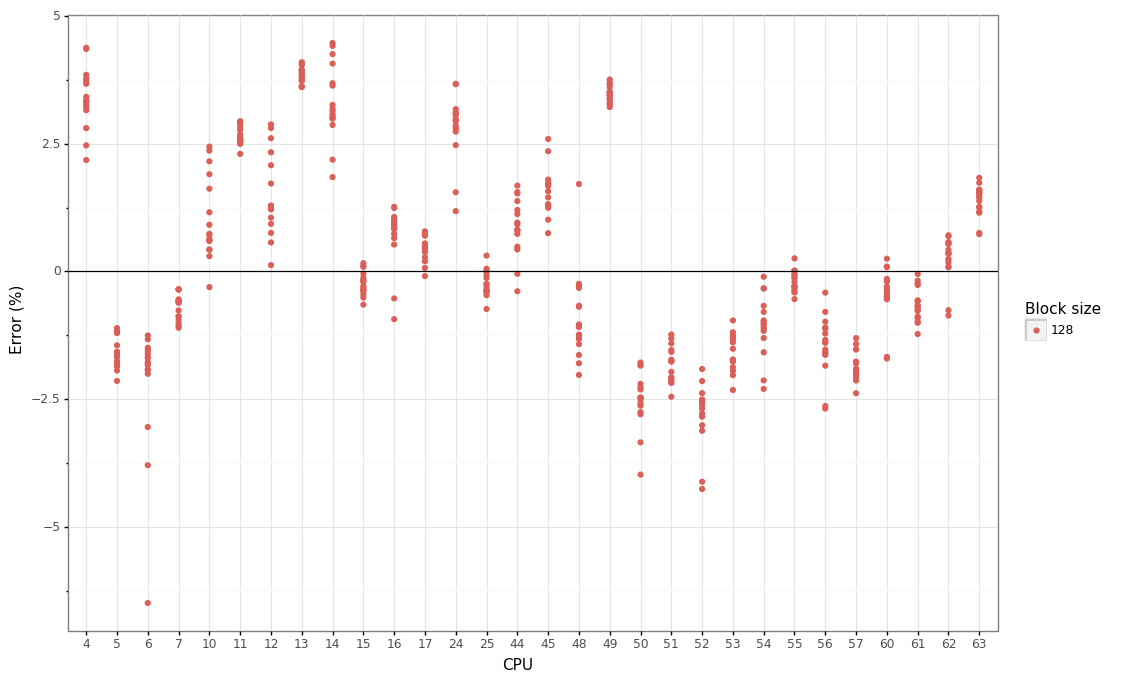

<ggplot: (8790261232858)>

In [23]:
tmp = summary.copy()
tmp['error'] *= 100
plot = ggplot(tmp, aes(x='factor(cpu)', y='error', color='factor(block_size)')) + geom_point() + theme_bw()
plot = plot + geom_hline(yintercept=0) + ylab('Error (%)') + xlab('CPU') + labs(color='Block size')
plot

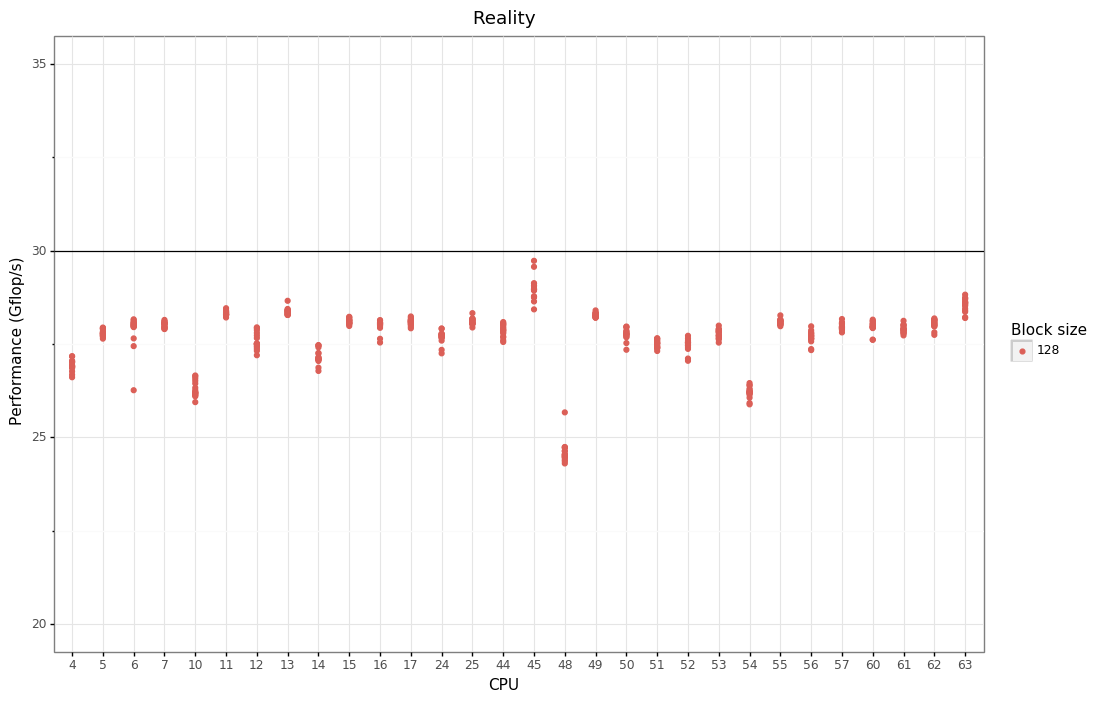

<ggplot: (8790261450111)>


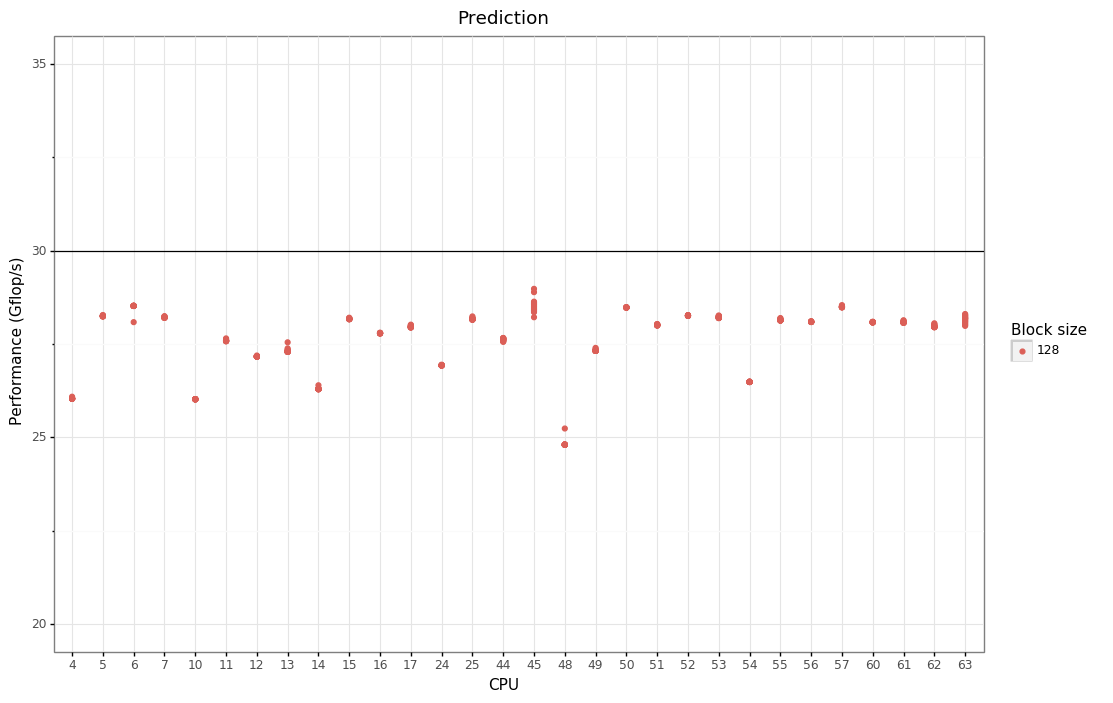

<ggplot: (-9223363246591055251)>


In [24]:
plot = ggplot(tmp, aes(x='factor(cpu)', color='factor(block_size)')) + theme_bw()
plot = plot + geom_hline(yintercept=30) + ylab('Performance (Gflop/s)') + xlab('CPU') + labs(color='Block size') + expand_limits(y=20) + expand_limits(y=35)
print(plot + geom_point(aes(y='gflops_real')) + ggtitle('Reality'))
print(plot + geom_point(aes(y='gflops_pred')) + ggtitle('Prediction'))

## Monitoring

In [25]:
import cashew
print(cashew.__git_version__)
from cashew import archive_extraction

f6e1abe82ebba1eec668652189985c631c10b5b5


In [26]:
archives = [archive]

In [27]:
dataframes = []
for f in archives:
    tmp = archive_extraction.read_monitoring(f)
    tmp['expfile'] = archive_extraction.read_yaml(f, 'info.yaml')['expfile'][0]
    dataframes.append(tmp)
monitoring = pandas.concat(dataframes)
monitoring['date'] = pandas.to_datetime(monitoring['start_time'], unit='s').astype(str)
for date in monitoring['date'].unique():
    monitoring.loc[monitoring['date'] == date, 'real_start_time'] = monitoring[monitoring['date'] == date]['timestamp'].min()
monitoring['start_exp'] -= monitoring['real_start_time']
monitoring['stop_exp'] -= monitoring['real_start_time']
monitoring['timestamp'] -= monitoring['real_start_time']
monitoring['cpu_id'] = monitoring['node'].astype(str) + ':' + monitoring['cpu'].astype(str)
monitoring['in_exp'] = (monitoring['timestamp'] > monitoring['start_exp'] + 60) & (monitoring['timestamp'] < monitoring['stop_exp'] - 60)
monitoring['hostname'] = monitoring['cluster'] + '-' + monitoring['node'].astype(str)
print(len(monitoring))
monitoring.head()

455872


,timestamp,cluster,node,jobid,start_time,expfile_hash,value,cpu,core,kind,start_exp,stop_exp,expfile,date,real_start_time,cpu_id,in_exp,hostname
0,0.001474,dahu,3,1939719,1594276706,26391bedb8a5b0cda2384036dfe876248b86d458e16559...,1.000396,0,0,frequency,639.786058,2370.594221,exp_hpl_small.csv,2020-07-09 06:38:26,1.594284e+09,3:0,False,dahu-3
1,5.014559,dahu,3,1939719,1594276706,26391bedb8a5b0cda2384036dfe876248b86d458e16559...,2.669091,0,0,frequency,639.786058,2370.594221,exp_hpl_small.csv,2020-07-09 06:38:26,1.594284e+09,3:0,False,dahu-3
2,10.026298,dahu,3,1939719,1594276706,26391bedb8a5b0cda2384036dfe876248b86d458e16559...,2.667169,0,0,frequency,639.786058,2370.594221,exp_hpl_small.csv,2020-07-09 06:38:26,1.594284e+09,3:0,False,dahu-3
3,15.042331,dahu,3,1939719,1594276706,26391bedb8a5b0cda2384036dfe876248b86d458e16559...,1.868133,0,0,frequency,639.786058,2370.594221,exp_hpl_small.csv,2020-07-09 06:38:26,1.594284e+09,3:0,False,dahu-3
4,20.054916,dahu,3,1939719,1594276706,26391bedb8a5b0cda2384036dfe876248b86d458e16559...,2.397363,0,0,frequency,639.786058,2370.594221,exp_hpl_small.csv,2020-07-09 06:38:26,1.594284e+09,3:0,False,dahu-3


In [28]:
grouped_mon = monitoring[monitoring.in_exp].groupby(['node', 'cpu', 'cpu_id', 'kind', 'expfile'])[['value']].mean().reset_index()
grouped_mon.head()

,node,cpu,cpu_id,kind,expfile,value
0,3,0,3:0,frequency,exp_hpl_small.csv,2.359355
1,3,0,3:0,temperature,exp_hpl_small.csv,74.078804
2,3,1,3:1,frequency,exp_hpl_small.csv,2.474617
3,3,1,3:1,temperature,exp_hpl_small.csv,64.660908
4,4,0,4:0,frequency,exp_hpl_small.csv,2.557716


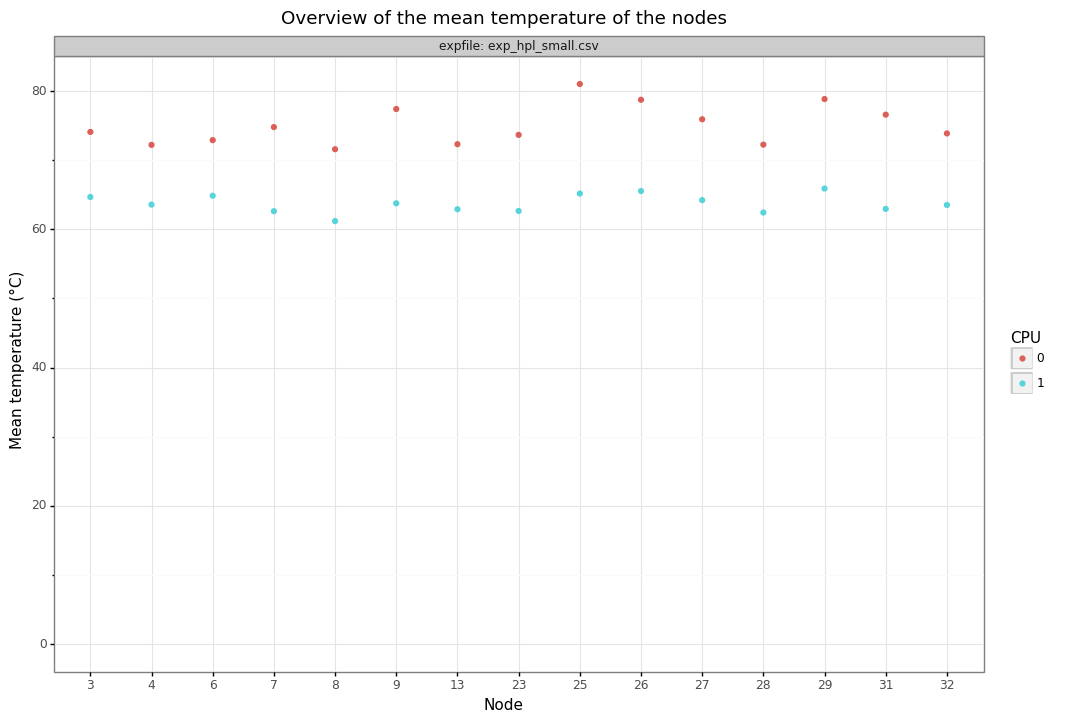

<ggplot: (-9223363246593684946)>

In [29]:
(ggplot(grouped_mon[grouped_mon['kind'] == 'temperature'])
    + aes(x='factor(node)', y='value', color='factor(cpu)')
    + geom_point()
    + theme_bw()
    + facet_wrap('expfile', labeller='label_both')
    + labs(x='Node', y='Mean temperature (°C)', color='CPU')
    + ggtitle('Overview of the mean temperature of the nodes')
    + expand_limits(y=0)
)

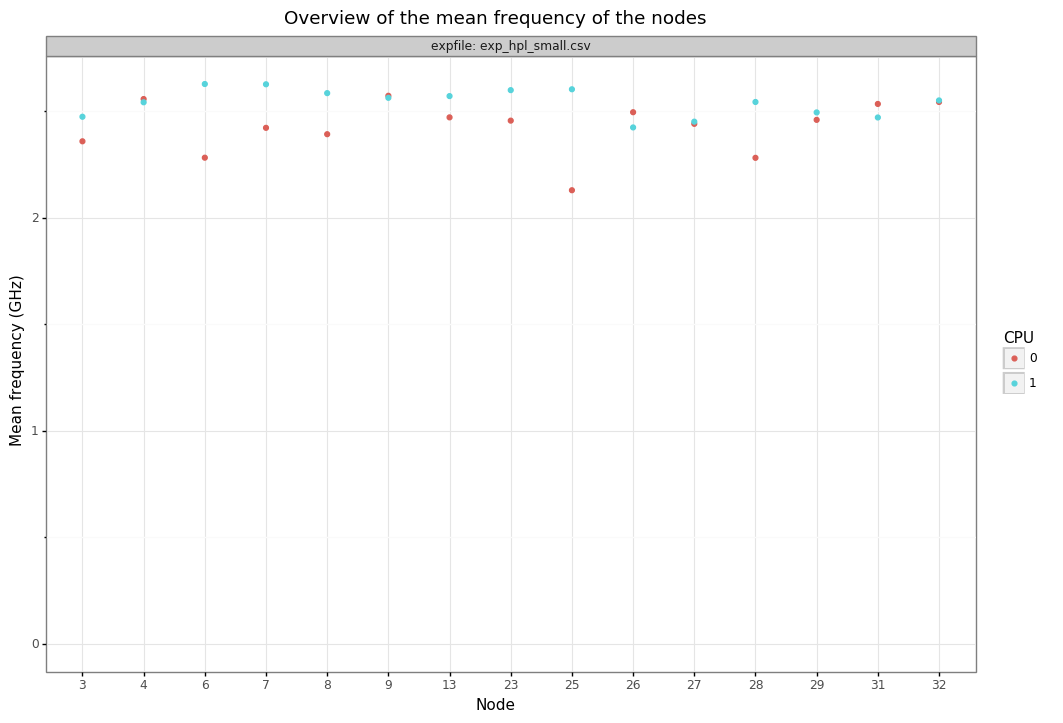

<ggplot: (8790261418374)>

In [30]:
(ggplot(grouped_mon[grouped_mon['kind'] == 'frequency'])
    + aes(x='factor(node)', y='value', color='factor(cpu)')
    + geom_point()
    + theme_bw()
    + facet_wrap('expfile', labeller='label_both')
    + labs(x='Node', y='Mean frequency (GHz)', color='CPU')
    + ggtitle('Overview of the mean frequency of the nodes')
    + expand_limits(y=0)
)

In [31]:
import re
reg = re.compile('power_package-(?P<cpu_id>[0-9]+)(_(?P<sub_group>[a-z]+))?')
reg.fullmatch('power_package-1').groupdict()

{'cpu_id': '1', 'sub_group': None}

In [32]:
import numpy
import re

def melt_power(df, idcol):
    reg = re.compile('power_package-(?P<cpu_id>[0-9]+)(_(?P<sub_group>[a-z]+))?')
    result = []
    columns = list(df.columns)
    for col in columns:
        match = reg.fullmatch(col)
        if match is None:
            continue
        tmp = df[idcol].copy()
        tmp['value'] = df[col]
        tmp['CPU'] = int(match.groupdict()['cpu_id'])
        tmp['subgroup'] = str(match.groupdict()['sub_group'])
        result.append(tmp)
    return pandas.concat(result)

def read_monitoring_power(archive_name, columns=None):
    '''
    Read the durations of a BLAS calibration in an archive.
    '''
    csv_name = 'monitoring.csv'
    df = archive_extraction.read_archive_csv_enhanced(archive_name, csv_name, columns=columns)
    df['timestamp'] = pandas.to_datetime(df['timestamp'])
    columns = ['timestamp', 'cluster', 'node', 'jobid', 'start_time', 'expfile_hash']
    power = melt_power(df, columns)
    power['timestamp'] = power['timestamp'].astype(numpy.int64) / 10 ** 9
    power['timestamp'] = power['timestamp'] - power['timestamp'].min()
    return power

dataframes = []
for f in archives:
    tmp = read_monitoring_power(f)
    tmp['expfile'] = archive_extraction.read_yaml(f, 'info.yaml')['expfile'][0]
    dataframes.append(tmp)
power = pandas.concat(dataframes)

for jobid in power['jobid'].unique():
    for col in ['start_exp', 'stop_exp']:
        val = monitoring[monitoring['jobid'] == jobid][col].unique()
        assert len(val) == 1
        power.loc[power['jobid'] == jobid, col] = val
power.head()

,timestamp,cluster,node,jobid,start_time,expfile_hash,value,CPU,subgroup,expfile,start_exp,stop_exp
0,0.001474,dahu,3,1939719,1594276706,26391bedb8a5b0cda2384036dfe876248b86d458e16559...,43.327609,1,None,exp_hpl_small.csv,639.786058,2370.594221
1,5.014559,dahu,3,1939719,1594276706,26391bedb8a5b0cda2384036dfe876248b86d458e16559...,54.128848,1,None,exp_hpl_small.csv,639.786058,2370.594221
2,10.026298,dahu,3,1939719,1594276706,26391bedb8a5b0cda2384036dfe876248b86d458e16559...,119.666074,1,None,exp_hpl_small.csv,639.786058,2370.594221
3,15.042331,dahu,3,1939719,1594276706,26391bedb8a5b0cda2384036dfe876248b86d458e16559...,81.306906,1,None,exp_hpl_small.csv,639.786058,2370.594221
4,20.054916,dahu,3,1939719,1594276706,26391bedb8a5b0cda2384036dfe876248b86d458e16559...,54.643235,1,None,exp_hpl_small.csv,639.786058,2370.594221


In [33]:
grouped_power = power[(power['timestamp'] > power['start_exp']+60) & (power['timestamp'] < power['stop_exp']-60)].groupby(['subgroup', 'node', 'CPU', 'expfile'])[['value']].mean().reset_index()
grouped_power.head()

,subgroup,node,CPU,expfile,value
0,None,3,0,exp_hpl_small.csv,124.638277
1,None,3,1,exp_hpl_small.csv,124.638494
2,None,4,0,exp_hpl_small.csv,124.637208
3,None,4,1,exp_hpl_small.csv,124.637046
4,None,6,0,exp_hpl_small.csv,124.637313


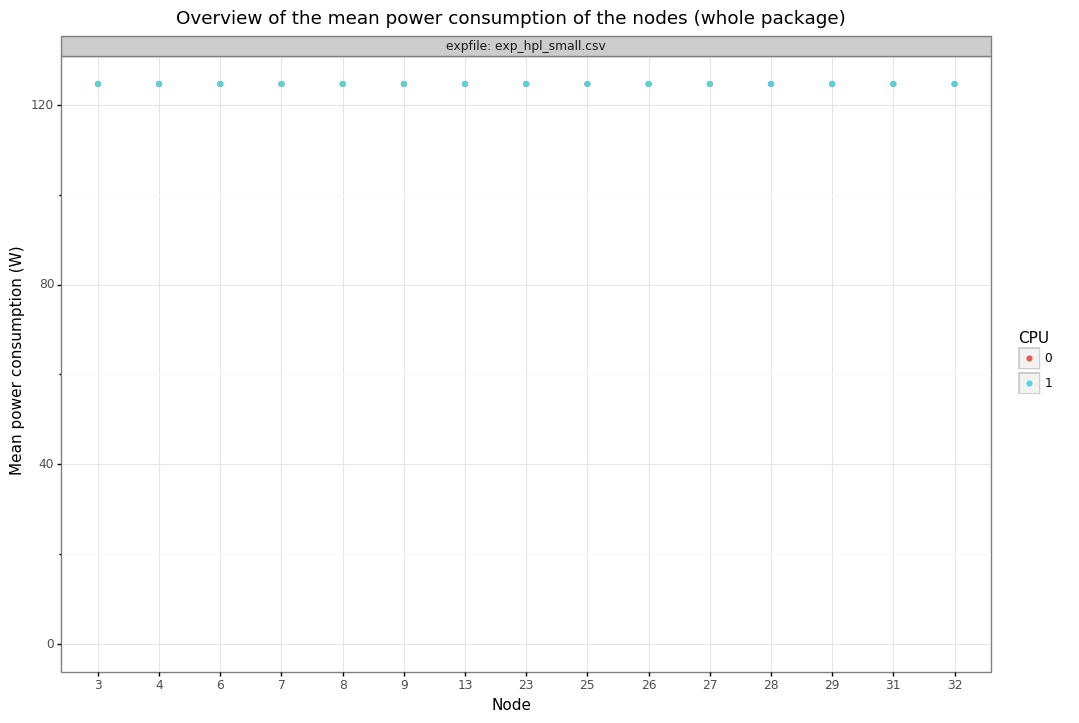

<ggplot: (-9223363246591080462)>

In [34]:
(ggplot(grouped_power[grouped_power['subgroup'] == 'None'])
    + aes(x='factor(node)', y='value', color='factor(CPU)')
    + geom_point()
    + theme_bw()
    + facet_wrap('expfile', labeller='label_both')
    + labs(x='Node', y='Mean power consumption (W)', color='CPU')
    + ggtitle('Overview of the mean power consumption of the nodes (whole package)')
    + expand_limits(y=0)
)

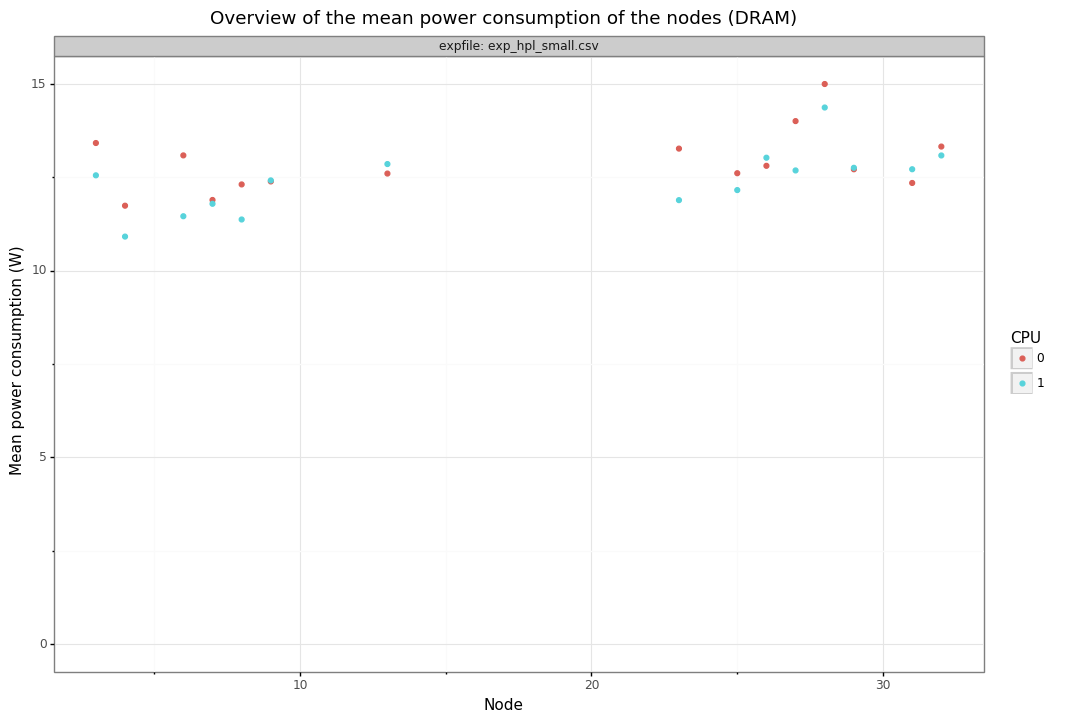

<ggplot: (-9223363246543718919)>

In [35]:
(ggplot(grouped_power[grouped_power['subgroup'] == 'dram'])
    + aes(x='node', y='value', color='factor(CPU)')
    + geom_point()
    + theme_bw()
    + facet_wrap('expfile', labeller='label_both')
    + labs(x='Node', y='Mean power consumption (W)', color='CPU')
    + ggtitle('Overview of the mean power consumption of the nodes (DRAM)')
    + expand_limits(y=0)
)